In [20]:
import hashlib
import os
import tarfile
import zipfile
import requests

#@save
DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

In [21]:
def download(name, cache_dir=os.path.join('.', 'data')):  #@save
    """下载一个DATA_HUB中的文件，返回本地文件名"""
    assert name in DATA_HUB, f"{name} 不存在于 {DATA_HUB}"
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname  # 命中缓存
    print(f'正在从{url}下载{fname}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname


def download_extract(name, folder=None):  #@save
    """下载并解压zip/tar文件"""
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, '只有zip/tar文件可以被解压缩'
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir


def download_all():  #@save
    """下载DATA_HUB中的所有文件"""
    for name in DATA_HUB:
        download(name)

In [22]:
# 如果没有安装pandas，请取消下一行的注释
# !pip install pandas

%matplotlib inline
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

In [23]:
DATA_HUB['kaggle_house_train'] = (  #@save
    DATA_URL + 'kaggle_house_pred_train.csv',
    '585e9cc93e70b39160e7921475f9bcd7d31219ce')

DATA_HUB['kaggle_house_test'] = (  #@save
    DATA_URL + 'kaggle_house_pred_test.csv',
    'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')

In [24]:
train_data = pd.read_csv(download('kaggle_house_train'))
test_data = pd.read_csv(download('kaggle_house_test'))

In [25]:
train_data.shape, test_data.shape

((1460, 81), (1459, 80))

In [26]:
train_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [27]:
# train_data中最后一列为预测值，test_data无预测值
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))

In [28]:
# 若无法获得测试数据，则可根据训练数据计算均值和标准差
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))
# 在标准化数据之后，所有均值消失，因此我们可以将缺失值设置为0
all_features[numeric_features] = all_features[numeric_features].fillna(0)

In [29]:
# “Dummy_na=True”将“na”（缺失值）视为有效的特征值，并为其创建指示符特征
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape

(2919, 331)

In [30]:
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32)
train_labels = torch.tensor(
    train_data['SalePrice'].values.reshape(-1, 1), dtype=torch.float32)

In [31]:
loss_fun = nn.MSELoss()
in_features = train_features.shape[1]


def get_net():
    """
    Create a single-layer linear network
    :return: A linear network
    """
    net = nn.Sequential(nn.Linear(in_features, 1))
    return net


def log_rmse(net, features, labels):
    # 为了在取对数时进一步稳定该值，将小于1的值设置为1
    clipped_pred = torch.clamp(net(features), 1, float('inf'))  # 将net(features)的输出限制到[1, +∞]上
    rmse = torch.sqrt(loss_fun(torch.log(clipped_pred),
                               torch.log(labels)))
    return rmse.item()


def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    # 这里使用的是Adam优化算法
    optimizer = torch.optim.Adam(net.parameters(),
                                 lr=learning_rate,
                                 weight_decay=weight_decay)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss_fun(net(X), y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

In [32]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid


def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay,
           batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
        print(f'折{i + 1}，训练log rmse{float(train_ls[-1]):f}, '
              f'验证log rmse{float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

折1，训练log rmse0.170107, 验证log rmse0.157118
折2，训练log rmse0.162184, 验证log rmse0.190834
折3，训练log rmse0.164066, 验证log rmse0.168685
折4，训练log rmse0.168010, 验证log rmse0.154675
折5，训练log rmse0.162982, 验证log rmse0.182724
5-折验证: 平均训练log rmse: 0.165470, 平均验证log rmse: 0.170807


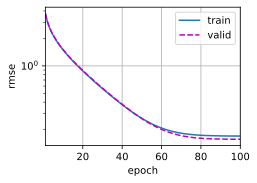

In [33]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')

折1，训练log rmse0.167519, 验证log rmse0.164770
折2，训练log rmse0.166182, 验证log rmse0.144253
折3，训练log rmse0.166417, 验证log rmse0.157143
折4，训练log rmse0.159537, 验证log rmse0.225708
折5，训练log rmse0.161414, 验证log rmse0.195982
折6，训练log rmse0.165834, 验证log rmse0.130445
折7，训练log rmse0.167150, 验证log rmse0.139076
折8，训练log rmse0.164027, 验证log rmse0.165403
折9，训练log rmse0.162351, 验证log rmse0.204816
折10，训练log rmse0.165662, 验证log rmse0.152831
10-折验证: 平均训练log rmse: 0.164609, 平均验证log rmse: 0.168043


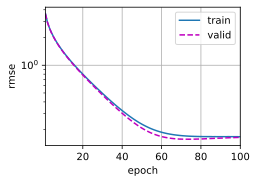

In [34]:
k, num_epochs, lr, weight_decay, batch_size = 10, 100, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')

折1，训练log rmse0.164449, 验证log rmse0.142591
折2，训练log rmse0.164480, 验证log rmse0.120818
折3，训练log rmse0.164078, 验证log rmse0.249636
折4，训练log rmse0.164282, 验证log rmse0.201240
折5，训练log rmse0.163958, 验证log rmse0.158405
折6，训练log rmse0.164917, 验证log rmse0.159443
折7，训练log rmse0.164302, 验证log rmse0.166608
折8，训练log rmse0.164730, 验证log rmse0.133062
折9，训练log rmse0.164107, 验证log rmse0.133081
折10，训练log rmse0.165059, 验证log rmse0.101429
折11，训练log rmse0.164991, 验证log rmse0.183020
折12，训练log rmse0.164586, 验证log rmse0.151957
折13，训练log rmse0.164507, 验证log rmse0.178834
折14，训练log rmse0.162642, 验证log rmse0.189344
折15，训练log rmse0.164684, 验证log rmse0.104602
折16，训练log rmse0.164032, 验证log rmse0.147166
折17，训练log rmse0.163733, 验证log rmse0.109594
折18，训练log rmse0.164350, 验证log rmse0.138261
折19，训练log rmse0.164576, 验证log rmse0.103667
折20，训练log rmse0.164307, 验证log rmse0.169637
折21，训练log rmse0.164982, 验证log rmse0.071665
折22，训练log rmse0.164617, 验证log rmse0.101242
折23，训练log rmse0.163941, 验证log rmse0.119808
折24，训练log rmse0.1643

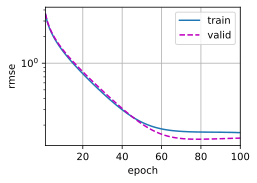

In [35]:
k, num_epochs, lr, weight_decay, batch_size = 100, 100, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')

折1，训练log rmse0.123523, 验证log rmse0.175355
折2，训练log rmse0.124436, 验证log rmse0.131934
折3，训练log rmse0.122933, 验证log rmse0.180548
折4，训练log rmse0.118029, 验证log rmse0.169887
折5，训练log rmse0.118573, 验证log rmse0.171767
折6，训练log rmse0.123947, 验证log rmse0.137972
折7，训练log rmse0.122432, 验证log rmse0.181080
折8，训练log rmse0.125016, 验证log rmse0.131007
折9，训练log rmse0.112699, 验证log rmse0.182691
折10，训练log rmse0.122627, 验证log rmse0.154439
10-折验证: 平均训练log rmse: 0.121421, 平均验证log rmse: 0.161668


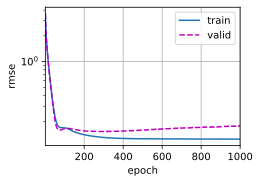

In [36]:
k, num_epochs, lr, weight_decay, batch_size = 10, 1000, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')

In [63]:
class A:
    def m(self):
        print('A')

    # def q(self):
    #     print('Aq')

class B(A):
    def m(self):
        print('B')


class C(B):
    def m(self):
        print('C')
        super(C, self).m()

    def q(self):
        print('Cq')


C().m()

C
B
